In [70]:
import scipy
import scipy.optimize  #this is its own package, need to import separately from scipy
from scipy import constants as const, special
from scipy.special import jv,kv,iv,jvp,kvp,ivp
import numpy as np
import math
import matplotlib.pyplot as plt

# Constants
eps0 = const.epsilon_0
ee = const.e
me = const.m_e

# Input
n0 = 1e8   # [cm-3] Background density
B0 = 150   # [G] Background magnetic field
a = 2      # [cm] Plasma column radius
b = 20     # [cm] Chamber radius
k_e = 1.23 # dielectric constant of region outside plasma (hydrogen = 1.23)
# https://www.kabusa.com/Dilectric-Constants.pdf

wp = np.sqrt((n0*1e6)*ee**2/(eps0*me)) # Plasma frequency
wc = ee*(B0*1e-4)/me # Gyro frequency

#dimensionless quantities
r = wc/wp
baa = b/a

#define: x = ka, y = w/wp, baa=b/a
def boundary_condition_tg(nn, y, x, baa, r):
    #these are in units of eps0
    eps1 = 1 - 1/(y**2 - r**2)
    eps2 = -r/(y*(y**2 - r**2))
    eps3 = 1 - 1/y**2
    
    Ta = x*np.sqrt(-eps3/eps1)
    
    if baa == 1:  #denominator goes to zero
        return jv(nn,Ta)
    else:
        lhs = eps1*Ta*jvp(nn,Ta)/jv(nn,Ta) + nn*eps2
        r_num = ivp(nn,x)*kv(nn,x*baa) - iv(nn,x*baa)*kvp(nn,x)
        r_dem = iv(nn,x) *kv(nn,x*baa) - iv(nn,x*baa)*kv(nn,x)
        rhs = k_e* x * r_num/r_dem
        return lhs-rhs

/usr/local/lib/python3.6/global-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/global-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


[ 0.57005701  2.27622762  4.03040304  5.77857786  7.52475248  9.26892689
 11.01510151 12.75927593 14.50345035 16.24962496 17.99379938 19.7379738 ]


(-100, 100)

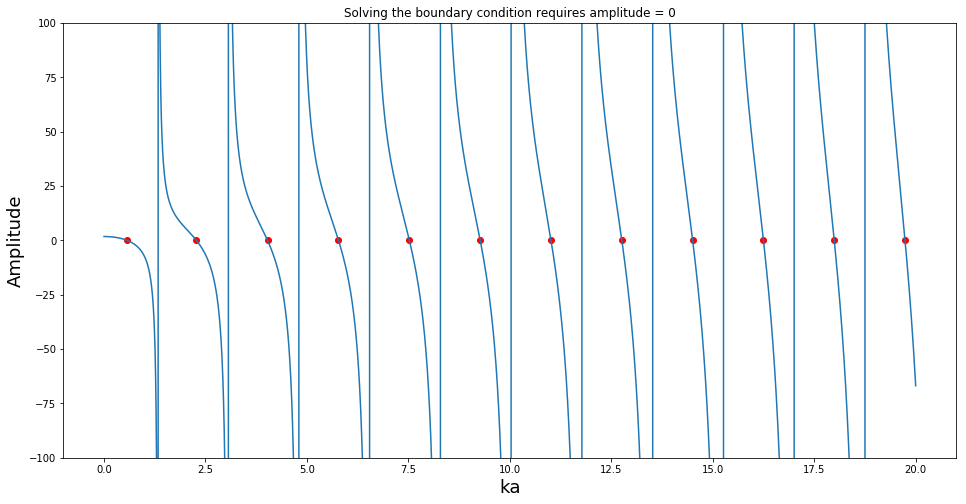

In [60]:
def root_find_arg(func): 
    sign_arr = np.sign(func)
    sign_arg = sign_arr[1:-1]-sign_arr[0:-2] #finds location of the sign flips
    sign_flip= np.where(np.abs(sign_arg) == 2)[0] #indices of all the sign flips
    
    zeros = []
    for ii in sign_flip:
        check = np.argsort(func[ii-1:ii+3]) # the 4 closest elements to the location of the sign flip
        # discard values caused by singularities (usually divergent at the sign flip)
        if (np.all(check == [3,2,1,0]) or np.all(check == [0,1,2,3])):
            zeros.append(ii)
#             break  #break after first root found
    
#     print('Root finder: '+str(len(zeros))+' root(s) found')
    return zeros #returns all the indices where the roots are located

#test plot example
order    = 0 # Order of the Bessel functions
x_range  = np.linspace(0, 20, 10000) #zero gives NaN, unitless ka
y_test   = 0.3 # some ratio of w/wp
baa_test = 2.0 # ratio of b/a
r_test   = 0.75 # ratio of wc/wp
bc_tg    = [boundary_condition_tg(order, y_test, xx, baa_test, r_test) for xx in x_range]
x_zeroes = np.array([x_range[ii] for ii in root_find_arg(bc_tg)])
print(x_zeroes)

plt.figure(figsize=(16,8))
plt.plot(x_range, bc_tg)
plt.scatter(x_zeroes, x_zeroes*0, c='r')
plt.title('Solving the boundary condition requires amplitude = 0')
plt.xlabel('ka', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.ylim(-100,100)

In [69]:
# Plotting dispersion relation as a function of a/b
# r_list = [0.2, 0.5, 0.75, 1, 4, 999] #no propagation below w>wc
# baa_plot=2
def get_zeroes(ylist, baa, rr):
    x_range = np.linspace(0, 20, 10000) #dimensionless, zero gives NaN
    order   = 0 # Order of the Bessel functions
    
    temp = []
    for yy in ylist:
        bc_tg       = [boundary_condition_tg(order, yy, xx, baa, rr) for xx in x_range]
        x_zeros_arg = root_find_arg(bc_tg)

        if len(x_zeros_arg) >= 1:
            x_zeros = x_range[x_zeros_arg[0]]
            print('\r', item, yy, x_zeros, end='...')
            temp.append(x_zeros)
        else:
            print('\r', item, yy, 0, end='...')
            temp.append(None)
    return(temp)

baa_list =[10, 5, 3, 2, 1.5, 1.25, 1.1, 1]
r_plot = r
x_list = {}
y_list = np.linspace(0, 1, 101) #defined y = w/wp

for item in baa_list:
    label = str(item)
    x_list[label] = get_zeroes(y_list, item, r)

/usr/local/lib/python3.6/global-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/global-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/global-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/global-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/global-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/global-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


 1 1.0 0...275727572757276...8874887489........

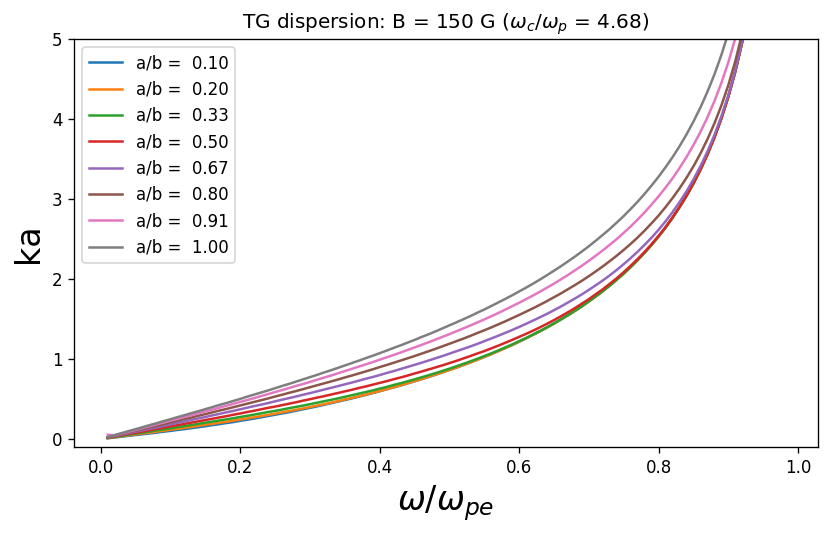

In [71]:
plt.figure(figsize=(8,4.5), dpi=120)
plt.xlabel('$\omega/\omega_{pe}$', fontsize=20)
plt.ylabel('ka', fontsize=20)
plt.title('TG dispersion: B = '+str(B0)+' G ($\omega_c$/$\omega_p$ ='+str(format(r,'5.2f'))+')') 
#, b/a = '+ str(b/a))

legends = []
for item in baa_list:
    label = str(item)
    plt.plot(y_list[0:-2], x_list[label][0:-2])
    legends.append('a/b = '+str(format(1/item, '5.2f')))

plt.legend(legends)
plt.ylim(-0.1, 5)
plt.savefig('tg_dispersion_abratio.png')

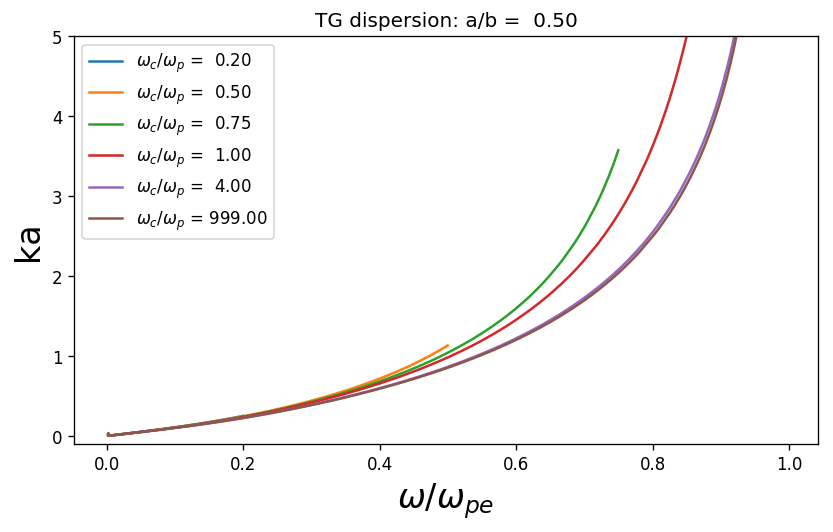

In [57]:
plt.figure(figsize=(8,4.5), dpi=120)
plt.xlabel('$\omega/\omega_{pe}$', fontsize=20)
plt.ylabel('ka', fontsize=20)
plt.title('TG dispersion: a/b = '+str(format(1/baa_plot, '5.2f'))) #, b/a = '+ str(b/a))

legends = []
for item in r_list:
    label = str(item)
    plt.plot(y_list, x_list[label])
    legends.append('$\omega_c$/$\omega_p$ = '+str(format(item, '5.2f')))

plt.legend(legends)
plt.ylim(-0.1,5)
plt.savefig('tg_dispersion_bfield.png')

In [ ]:
#### below is Jia's code for reference

In [330]:
def find_root(func, x):
    
    retry_count = 0
    
    while retry_count < 30:
        try:
            x = np.linspace(rang[0], rang[1],10000)    
            # generates initial guesses   
            ls1 = np.gradient(np.sign(func(x))) # Find where the function test array crosses zero
            ls2 = np.where(ls1 != 0 ) # This gives you the index of initial guess

            # what happens here is ls2 will have a bunch of points that are not real zero crossing of the function.
            # You might want to check by plotting if fsolve is not giving you a reasonable result.
            # If they don't come out right, you need to play around with what points to use in x[ls2] till it's right.

            ls3 = scipy.optimize.fsolve(func,x[ls2][2::2])    # Find root with initial guess
            ls4 = np.unique(np.round(ls3,4)) # Remove duplicate result keeping 4 decimal place
            
            return np.sort(ls4) # return roots in ascending order
            
        except TypeError:
            rang[1] += 1
            retry_count += 1
    
    print ('Did not find any possible initial guess for roots')
    return None

/usr/local/lib/python3.6/global-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/global-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()


[0.2032 0.8624]


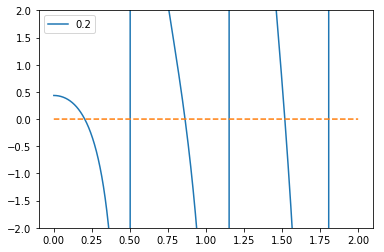

In [331]:
rang = [0,0.05] # Initial range for root finding
x = np.linspace(0, 2,10000)   # x=ka (dimensionless wavenumber)
y = 0.2 # y = w/wp (dimensionless frequency)
n = 0 # Order of Bessel functions

def f(x): # Define the function you want to find root here

    Ta = x * np.sqrt(-(y**2-1)*(y**2-r**2)/(y**2*(y**2-1-r**2)))

    k1 = 1-1/(y**2-r**2)
    k2 = -r/(y*(y**2-r**2))

    LHS = k1*Ta*jvp(n,Ta)/jv(n,Ta)+n*k2

    Num = ivp(n,x) * kv(n,b/a*x) - iv(n,b/a*x) * kvp(n,x)
    Den = iv(n,x)  * kv(n,b/a*x) - iv(n,b/a*x) * kv(n,x)
    
    RHS = x*Num/Den

    return LHS-RHS

roots = find_root(f,rang)

plt.figure(1)
plt.plot(x,f(x), label=y)
plt.plot(x,x*0,'--')
#plt.scatter(roots, roots*0)
plt.ylim(-2,2)
plt.legend()
print(roots)